# Feature Representations

In [1]:
import cv2
import numpy as np
from skimage.feature import hog
from skimage.feature import local_binary_pattern

def extract_combined_features(image):
    # Extract all features
    color_features = extract_color_features(image)
    lbp_features = extract_lbp_features(image)
    hog_features = extract_hog_features(image)
    
    # Combine all features
    combined_features = np.concatenate([color_features, lbp_features, hog_features])
    
    return combined_features

def extract_color_features(img):
    # Convert to different color spaces
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    
    # Compute color histograms
    hist_rgb = cv2.calcHist([img], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    hist_hsv = cv2.calcHist([hsv], [0, 1, 2], None, [8, 8, 8], [0, 180, 0, 256, 0, 256])
    hist_lab = cv2.calcHist([lab], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    
    # Flatten and normalize histograms
    hist_rgb = hist_rgb.flatten() / hist_rgb.sum()
    hist_hsv = hist_hsv.flatten() / hist_hsv.sum()
    hist_lab = hist_lab.flatten() / hist_lab.sum()
    
    # Compute mean and std for each channel
    means_rgb = img.mean(axis=(0, 1))
    stds_rgb = img.std(axis=(0, 1))
    
    return np.concatenate([hist_rgb, hist_hsv, hist_lab, means_rgb, stds_rgb])

def extract_lbp_features(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Set LBP parameters
    radius = 3  # Radius of the circle
    n_points = 8 * radius  # Number of points to consider in the LBP calculation
    
    # Compute the LBP representation of the image
    lbp = local_binary_pattern(gray, n_points, radius, method='uniform')
    
    # Compute the histogram of the LBP
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
    
    # Normalize the histogram
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-7)  # Avoid division by zero
    
    return hist

def extract_hog_features(image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), orientations=9):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    features = hog(gray, orientations=orientations, pixels_per_cell=pixels_per_cell,
                   cells_per_block=cells_per_block, block_norm='L2-Hys', feature_vector=True)
    return features

def extract_sift_features(image, num_features=100):
    sift = cv2.SIFT_create(nfeatures=num_features)
    keypoints, descriptors = sift.detectAndCompute(image, None)
    if descriptors is None:
        return np.zeros((num_features, 128))  # SIFT descriptor is 128-dimensional
    if descriptors.shape[0] < num_features:
        padding = np.zeros((num_features - descriptors.shape[0], 128))
        descriptors = np.vstack((descriptors, padding))
    return descriptors[:num_features].flatten()

def extract_surf_features(image, num_features=100, hessian_threshold=400):
    surf = cv2.xfeatures2d.SURF_create(hessianThreshold=hessian_threshold, nOctaves=4, nOctaveLayers=3, extended=False, upright=True)
    keypoints, descriptors = surf.detectAndCompute(image, None)
    if descriptors is None:
        return np.zeros((num_features, 64))  # SURF descriptor is 64-dimensional
    if descriptors.shape[0] < num_features:
        padding = np.zeros((num_features - descriptors.shape[0], 64))
        descriptors = np.vstack((descriptors, padding))
    return descriptors[:num_features].flatten()

def extract_features(image, method):
    # HOG
    if method == 'HOG':
        return extract_hog_features(image)
    
    # SIFT
    if method == 'SIFT':
        return extract_sift_features(image)
        
    # SURF
    if method == 'SURF':
        return extract_surf_features(image)
    
    if method == 'Combined':
        return extract_combined_features(image)


def create_pixel_features(image, mask, method):
    X = extract_features(image, method)
    y = np.apply_along_axis(lambda x: x[0], 1, mask.reshape(-1,3))
    return X, y

Creating our training and testing sets

In [2]:
import os
from sklearn.model_selection import train_test_split
import random

target_size = (256, 256)

# Used for training on all V datasets (K datasets are corrupted after downloading from Sharepoint)
def get_input_output_paths(root_dir, sub_dirs, max_samples=None):
    input_paths = []
    target_paths = []
    samples_per_dir = max_samples // len(sub_dirs) if max_samples else None
    for sub_dir in sub_dirs:
        input_dir = os.path.join(root_dir, sub_dir, 'image')
        sub_input_paths = [os.path.join(input_dir, f) for f in os.listdir(input_dir)]
        random.shuffle(sub_input_paths)
        sub_target_paths = list(map(lambda x: x.replace("image", "indexLabel"), sub_input_paths))
        
        if samples_per_dir:
            sub_input_paths = sub_input_paths[:samples_per_dir]
            sub_target_paths = sub_target_paths[:samples_per_dir]
        
        input_paths.extend(sub_input_paths)
        target_paths.extend(sub_target_paths)
    return input_paths, target_paths

input_img_paths, _ = get_input_output_paths('WildScenes2d', ['V-01', 'V-02', 'V-03'], 50)

def resize_image_and_mask(image, mask, target_size):
    image_resized = cv2.resize(image, target_size)
    mask_resized = cv2.resize(mask, target_size, interpolation=cv2.INTER_NEAREST)
    return image_resized, mask_resized

X_all = []
y_all = []

for img_path in input_img_paths:
    img = np.asarray(cv2.imread(img_path))
    mask = np.asarray(cv2.imread(img_path.replace('image', 'indexLabel')))
    img, mask = resize_image_and_mask(img, mask, target_size)
    img, mask = create_pixel_features(img, mask, method='Combined')
    X_all.append(img)
    y_all.append(mask)

X = np.array(X_all)
y = np.array(y_all)

def get_majority_values(arr):
    flat_arr = arr.flatten()
    
    # Get unique values and their counts
    unique, counts = np.unique(flat_arr, return_counts=True)
    
    # Find the maximum count
    max_count = counts.max()
    
    # Get all values with the maximum count
    majority_values = unique[counts == max_count]
    
    return majority_values[0]

majority_values = np.apply_along_axis(get_majority_values, 1, y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

In [3]:
print(len(input_img_paths))
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
# print(np.unique(majority_values))
# print(np.count(2))
print(majority_values)

48
(36, 36164)
(12, 36164)
(36, 65536)
(12, 65536)
[ 8  8  8  8  8  8  8  8  8  8 17  8  8  2  8 17  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8 18  8 18  8  8  8  8  2]


In [4]:
def element_proportions(arr):
    flat_arr = arr.flatten()
    unique, counts = np.unique(flat_arr, return_counts=True)  
    total = len(flat_arr)
    proportions = counts / total    
    return dict(zip(unique, proportions))

print(element_proportions(y))
print(element_proportions(y_train))
print(element_proportions(y_test))

{2: 0.09293238321940105, 3: 1.52587890625e-05, 4: 8.900960286458333e-05, 5: 0.0003077189127604167, 7: 0.12214819590250652, 8: 0.5235211054484049, 9: 0.014310518900553385, 12: 0.00023174285888671875, 14: 0.0001618067423502604, 15: 0.0045604705810546875, 16: 0.0009314219156901041, 17: 0.08045291900634766, 18: 0.1603374481201172}
{2: 0.10052066379123265, 3: 2.0345052083333332e-05, 4: 0.00011867947048611111, 5: 0.0002772013346354167, 7: 0.12850062052408853, 8: 0.5262599521213107, 9: 0.0128173828125, 12: 0.00018480088975694444, 14: 0.00012376573350694444, 15: 0.003792656792534722, 16: 0.0009735955132378472, 17: 0.07640796237521702, 18: 0.1500023735894097}
{2: 0.07016754150390625, 5: 0.0003992716471354167, 7: 0.10309092203776042, 8: 0.5153045654296875, 9: 0.018789927164713543, 12: 0.0003725687662760417, 14: 0.0002759297688802083, 15: 0.006863911946614583, 16: 0.000804901123046875, 17: 0.09258778889973958, 18: 0.1913426717122396}


Fitting the model

In [5]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(max_depth=10, max_leaf_nodes=50, n_estimators=10, random_state=42, verbose=2)
rf.fit(X_train, y_train)

building tree 1 of 10
building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


RandomForestClassifier(max_depth=10, max_leaf_nodes=50, n_estimators=10,
                       random_state=42, verbose=2)

Gathering model predictions

In [6]:
y_pred = rf.predict(X_test)

Model evaluation using IOU

In [12]:
from sklearn.metrics import jaccard_score, accuracy_score, f1_score

y_pred_whole = np.concatenate(y_pred)
y_test_whole = np.concatenate(y_test)
iou = jaccard_score(y_test_whole, y_pred_whole, labels=[x for x in range(19)], average=None)
print(f'IoU for each class: {iou}')
print(f'Mean IoU: {np.mean(iou)}')
print(f'Accuracy: {accuracy_score(y_test_whole, y_pred_whole)}')
print(f'F1: {f1_score(y_test_whole, y_pred_whole, labels=[x for x in range(19)], average=None)}')

IoU for each class: [0.         0.         0.28284581 0.         0.         0.
 0.         0.05055332 0.64526037 0.         0.         0.
 0.         0.         0.         0.         0.         0.21435804
 0.38068484]
Mean IoU: 0.08282644095365642
Accuracy: 0.6278699239095052
F1: [0.         0.         0.44096618 0.         0.         0.
 0.         0.09624133 0.78438693 0.         0.         0.
 0.         0.         0.         0.         0.         0.35303927
 0.5514435 ]


c:\Users\kylew\Dev\9517\ass1\Semantic-Image-Segmentation-Techniques\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\kylew\Dev\9517\ass1\Semantic-Image-Segmentation-Techniques\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [8]:
colours = [[0, 0, 0], 
           [75, 25, 230], 
           [75, 180, 60], 
           [25, 225, 255], 
           [200, 130, 0], 
           [180, 30, 145], 
           [240, 240, 70], 
           [230, 50, 240], 
           [60, 245, 210], 
           [75, 25, 230], 
           [128, 128, 0], 
           [40, 110, 170], 
           [200, 250, 255], 
           [0, 0, 128], 
           [195, 255, 170], 
           [0, 128, 128], 
           [190, 190, 250], 
           [128, 0, 0], 
           [128, 128, 128]]

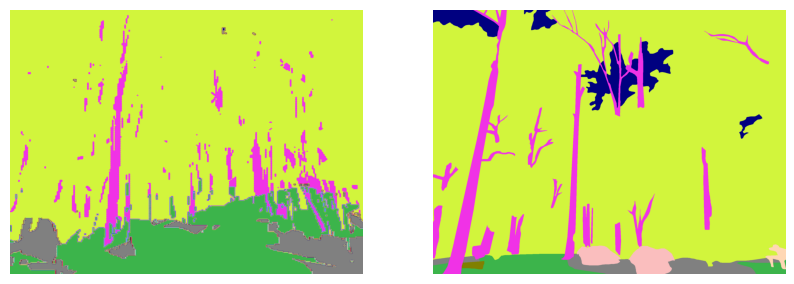

In [14]:
path = "1623377790-818434554"
img1 = cv2.imread(f'WildScenes2d/V-01/image/{path}.png')
img1 = cv2.resize(src=img1, dsize=(256, 256))
features = extract_combined_features(img1)
y_pred1 = rf.predict([features])
y_pred1 = y_pred1.reshape(256,256)
y_pred1 = cv2.resize(y_pred1, (2016, 1512))
result1 = np.array([[colours[num] for num in row] for row in y_pred1])
actual1 = cv2.imread(f'WildScenes2d/V-01/label/{path}.png')


import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.axis('off')
plt.imshow(cv2.cvtColor(result1.astype(np.uint8), cv2.COLOR_BGR2RGB))
plt.subplot(1, 2, 2)
plt.axis('off')
plt.imshow(cv2.cvtColor(actual1, cv2.COLOR_BGR2RGB))
plt.show()